#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [115]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from random import choice
import random

In [116]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [117]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    self.length = length
    if array is None:
      self.array = list(choice(list(product(range(2), repeat=length))))
    else:
      self.array = array

  def decode(self, lower_bound, upper_bound, aoi):
    cut = self.array[lower_bound:upper_bound+1]
    value = 0
    for i in range(len(cut)):
      value += (2 ** i)*cut[i]
    return min_max_norm(value, 0, 2**len(cut)-1, aoi[0], aoi[1])

  def mutation(self, probability):
    for i in range(len(self.array)):
      success = random.random() < probability
      if success:
        self.array[i] ^= 1
      
  def crossover(self, other):
    point = random.choice(range(len(self.array)))
    self.array[:point+1], other.array[:point+1] = other.array[:point+1], self.array[:point+1]
  
  def slice(self, nr_of_slices):
    slices = []
    slice_length = len(self.array)//nr_of_slices
    for i in range(0, len(self.array), slice_length):
      # "slicing" chromosome into n=obj_func_num_args new chromosomes
      slices.append(Chromosome(slice_length, self.array[i:i + slice_length]))
    return slices

  def copy(self):
    copy = Chromosome(self.length, self.array.copy())
    return copy

In [118]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.population_size = population_size
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps

  def eval_objective_func(self, chromosome:Chromosome):
    arguments = self.get_arguments_from_chrom(chromosome)
    return self.objective_function(*arguments)

  def get_arguments_from_chrom(self, chromosome):
    # decoding chromosome as n=obj_func_args arguments
    return [chrom.decode(0, len(chrom.array), self.aoi) for chrom in chromosome.slice(self.obj_func_num_args)]

  def tournament_selection(self, chromosomes):
    func_value_for_chromosome = {}
    for chromosome in chromosomes:
      func_value_for_chromosome[self.eval_objective_func(chromosome)] = chromosome
    return func_value_for_chromosome[min(func_value_for_chromosome)].copy()

  def reproduce(self, parents):
    for i in range(len(parents)-1):
        # crossover for each pair
        if random.random() < self.crossover_probability:
          parents[i].crossover(parents[i+1])
    for chromosome in parents:
        chromosome.mutation(self.mutation_probability)


  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 15)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self):
    old_population = []
    func_values = []
    # generating start population
    for _ in range(self.population_size):
      old_population.append(Chromosome(self.chromosome_lengths))
    for _ in range(self.num_steps):
      new_population = [] 
      func_values_for_population = {}
      trace = []
      for i in range(self.population_size):
        tournament_participants = []
        for _ in range(self.tournament_size):
          # generating group for tournament
          tournament_participants.append(choice(old_population))
        # tournament for each group
        winner = self.tournament_selection(tournament_participants)
        new_population.append(winner)
        # adding the best representative to the dict
        func_values_for_population[self.eval_objective_func(winner)] = self.get_arguments_from_chrom(winner)
      self.reproduce(new_population)
      func_values_for_population = dict(sorted(func_values_for_population.items()))
      func_values.append((min(func_values_for_population), func_values_for_population[min(func_values_for_population)]))
      old_population = new_population
      trace = list(func_values_for_population.values())[:20]
      self.plot_func(trace)
    trace = [arguments for value, arguments in func_values]
    self.plot_func(trace)
    return new_population

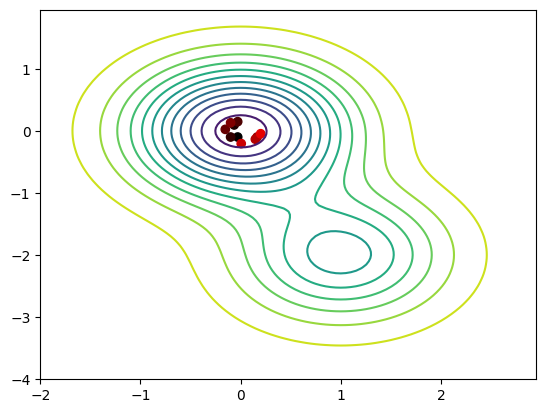

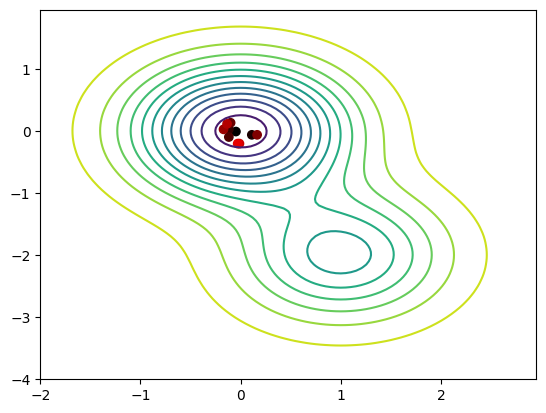

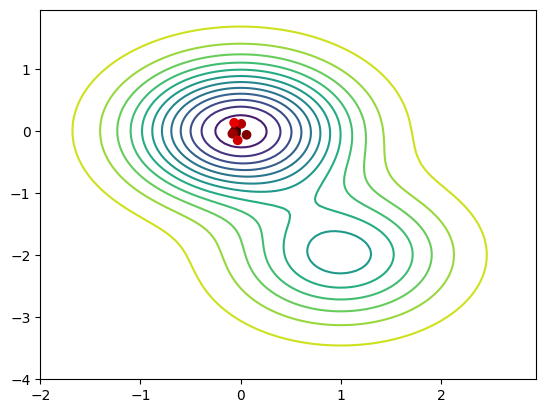

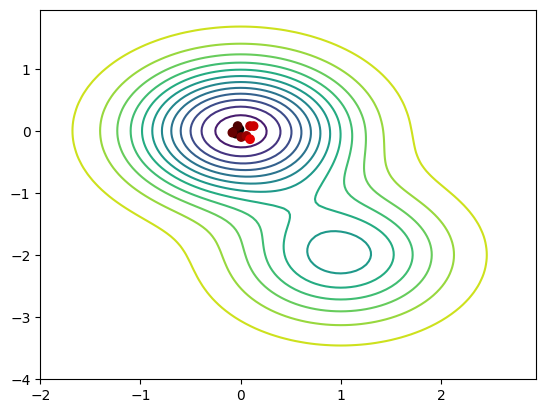

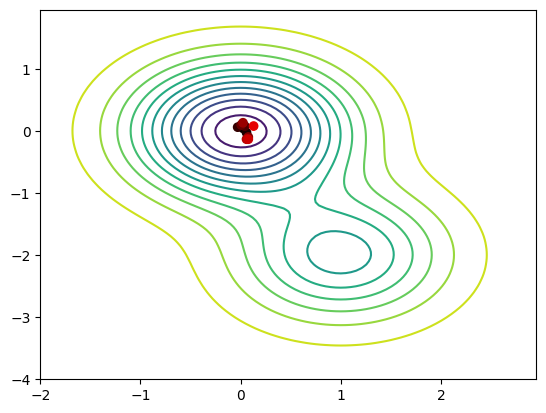

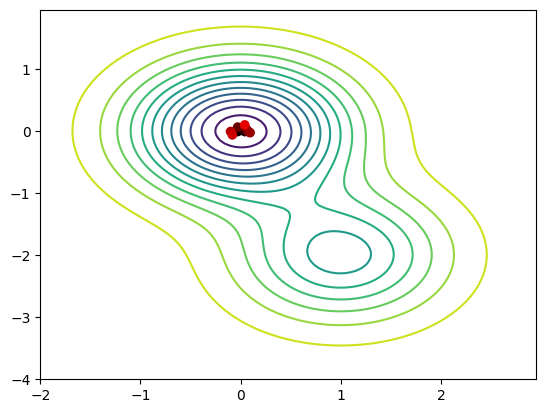

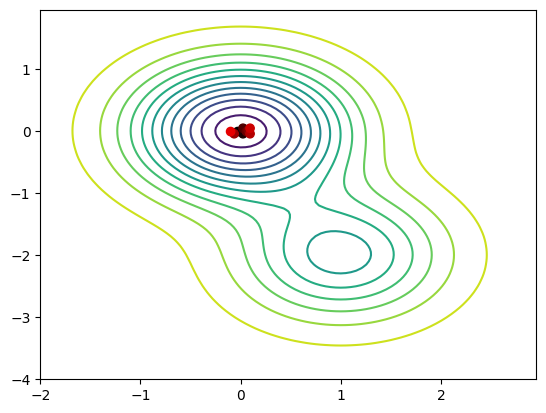

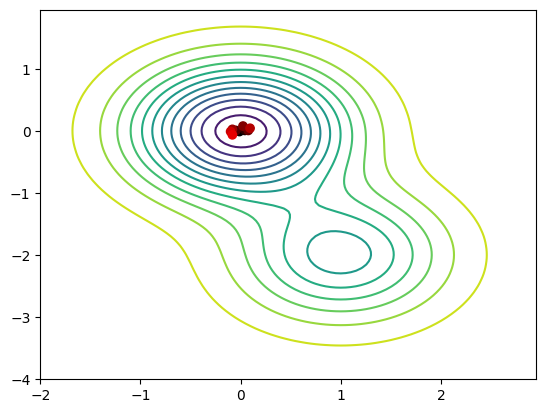

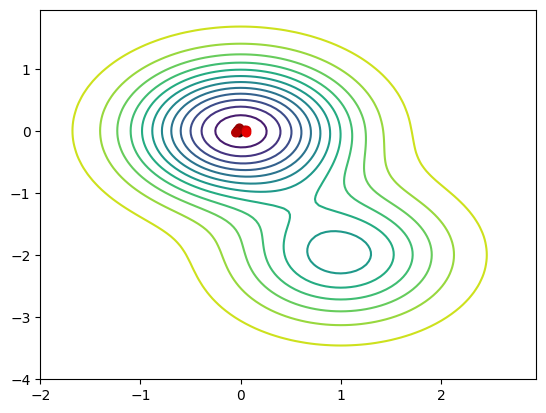

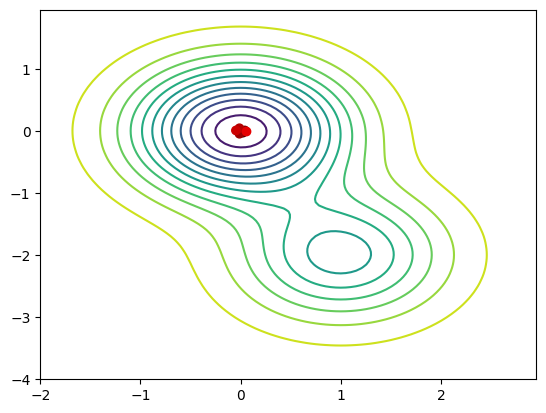

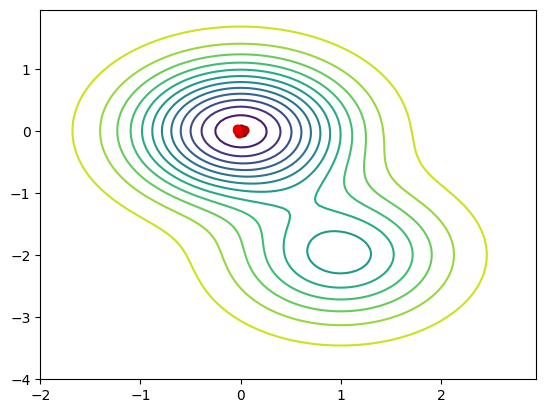

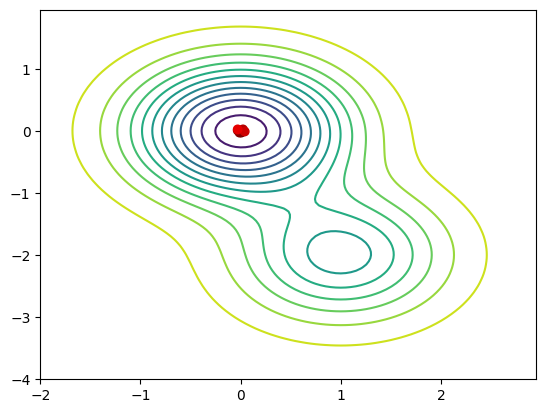

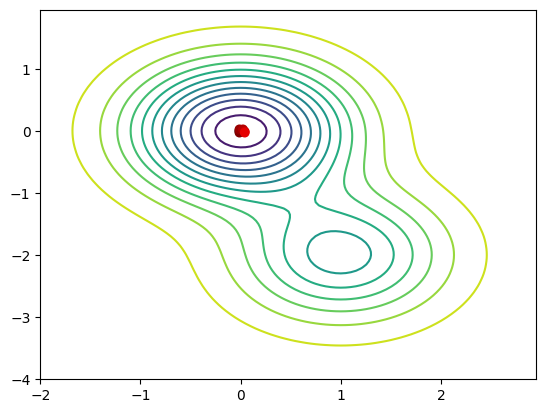

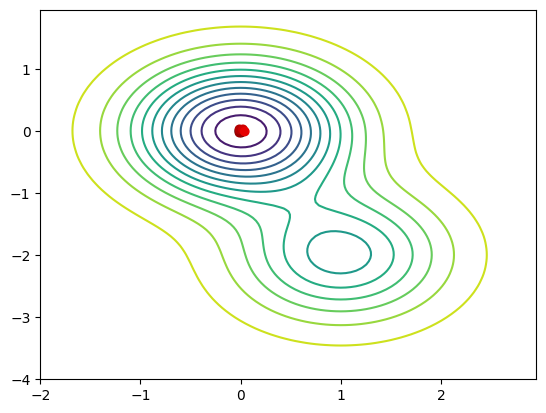

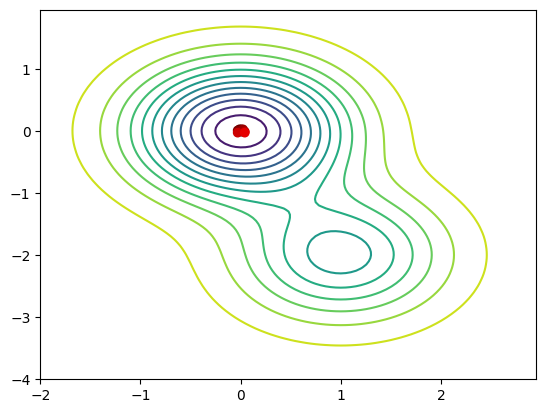

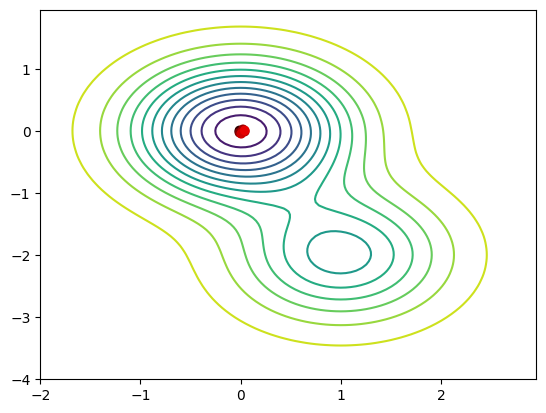

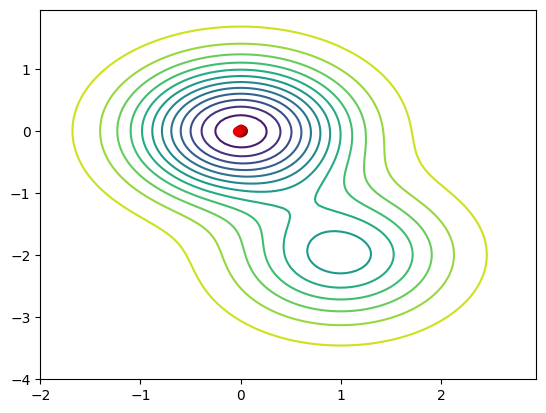

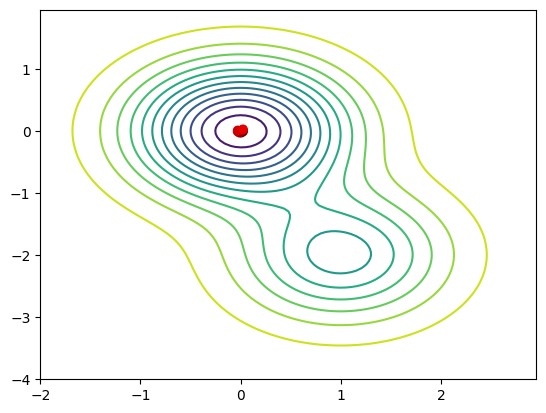

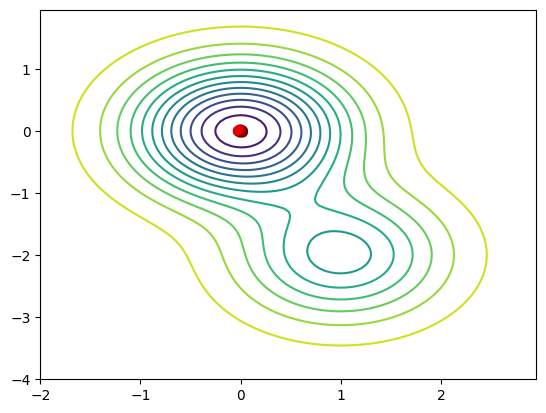

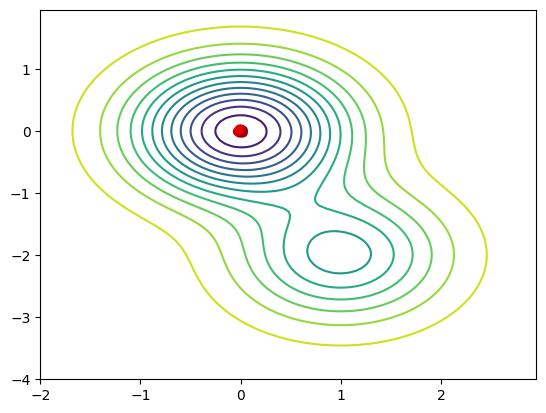

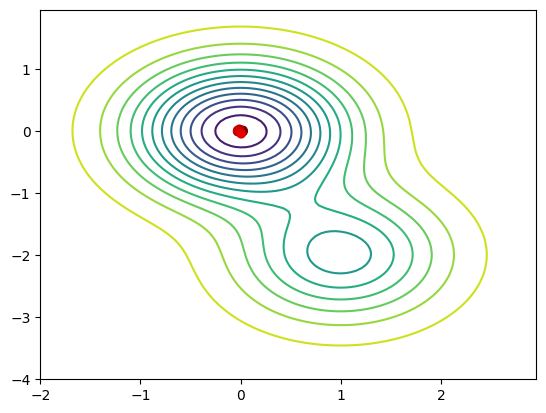

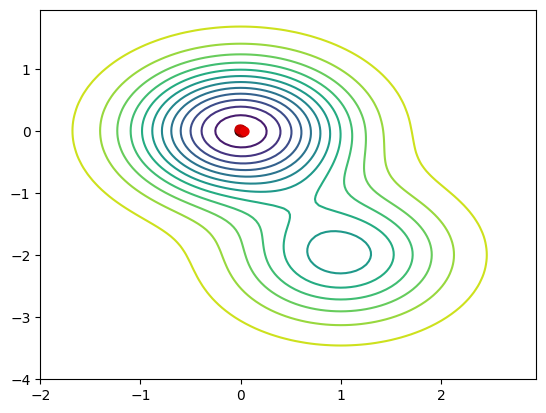

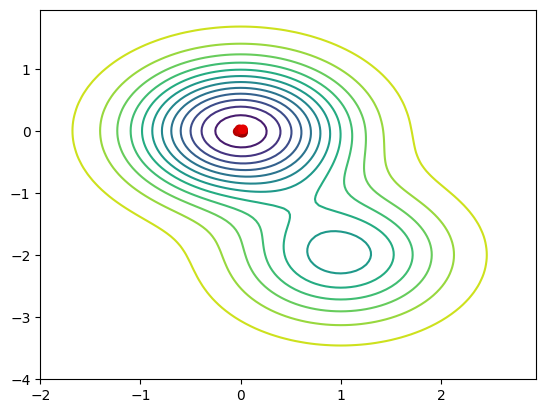

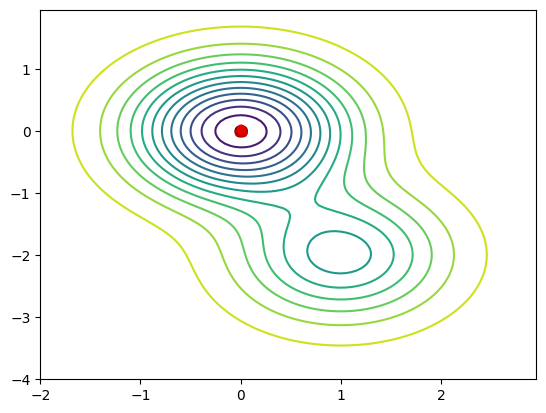

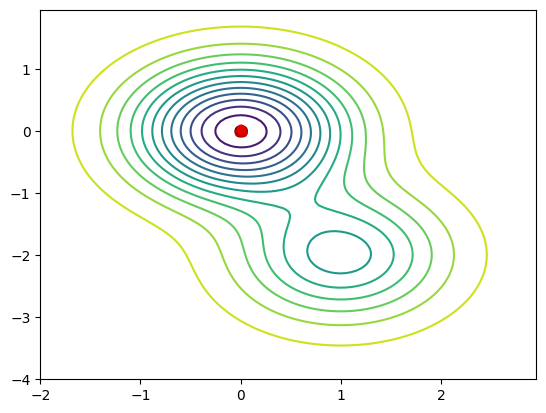

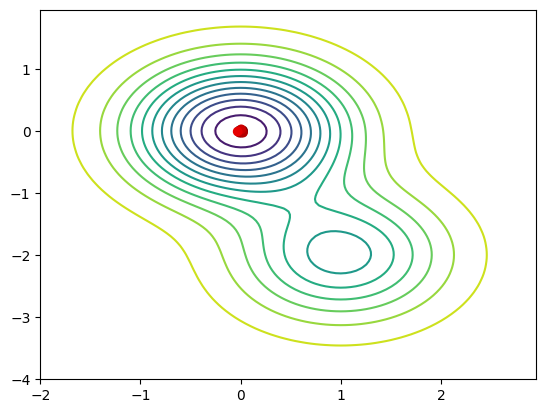

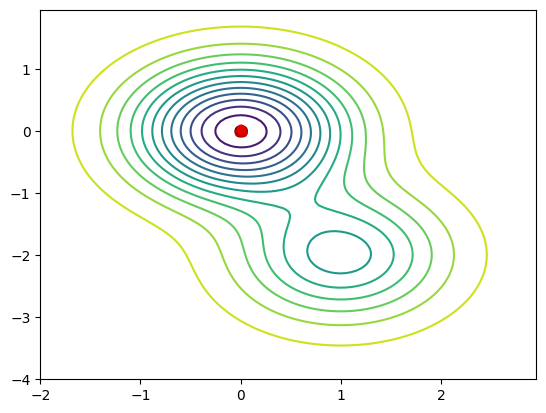

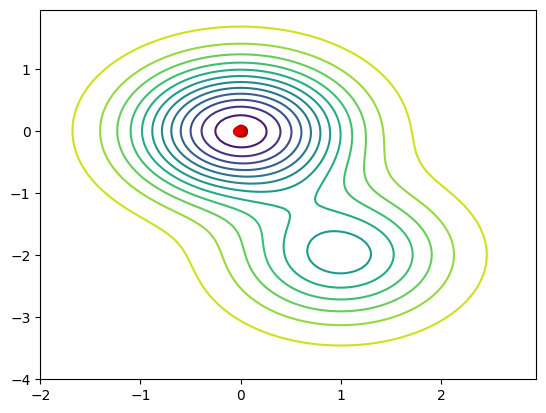

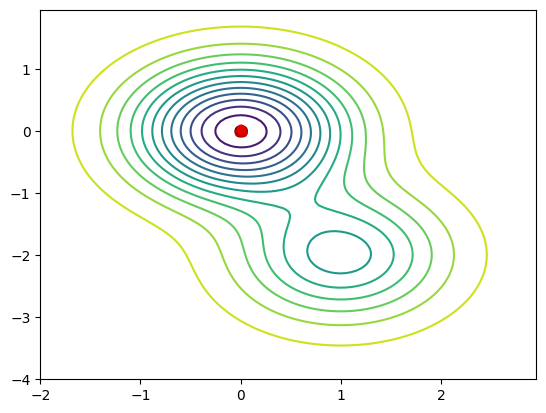

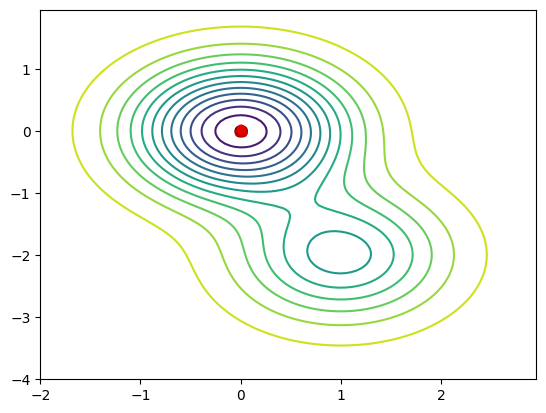

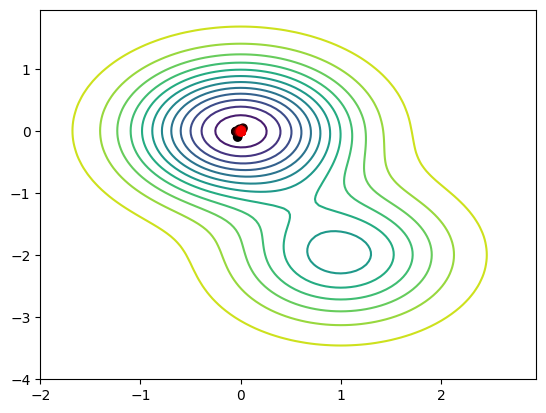

In [119]:
alg = GeneticAlgorithm(16,2, lambda X, Y: 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2)), [-2.5,2])
population = alg.run()